In [1]:
import pandas as pd
import numpy as np
import scanpy.api as sc
import anndata
import os
import subprocess

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2 anndata==0.6.4 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.0 


The fourth pancreas notebook, this time running Scanorama.

Scanorama filters its cells to a minimum of 600 genes, so let's do the same to make it possible to easily use the annotation.

In [2]:
adata = sc.read('objects-pancreas/pancreas.h5ad')
adata = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs)
sc.pp.filter_cells(adata, min_genes=600)

Attempts to run Scanorama within a Jupyter Notebook have been unsuccessful. However, exporting the data outside of the notebook and running Scanorama's entire workflow, including turning the data into `.npz` pickles results in functional output. So let's export the rawest form of the count matrices for Scanorama to process.

This notebook won't run immediately on your system as you need a Scanorama GitHub clone. I put mine in the same directory as BBKNN, as you'll notice by the paths.

In [3]:
df1 = pd.DataFrame(data=adata[adata.obs['sample']=='Baron'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Baron'].var_names,
                  columns=np.arange(np.sum(adata.obs['sample']=='Baron')))

df2 = pd.DataFrame(data=adata[adata.obs['sample']=='Muraro'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Muraro'].var_names,
                  columns=np.arange(np.sum(adata.obs['sample']=='Muraro')))

df3 = pd.DataFrame(data=adata[adata.obs['sample']=='Segerstolpe'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Segerstolpe'].var_names,
                  columns=np.arange(np.sum(adata.obs['sample']=='Segerstolpe')))

df4 = pd.DataFrame(data=adata[adata.obs['sample']=='Wang'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Wang'].var_names,
                  columns=np.arange(np.sum(adata.obs['sample']=='Wang')))

if not os.path.exists('../../scanorama/data/4panc'):
    os.makedirs('../../scanorama/data/4panc')
df1.to_csv('../../scanorama/data/4panc/baron.txt',sep='\t')
df2.to_csv('../../scanorama/data/4panc/muraro.txt',sep='\t')
df3.to_csv('../../scanorama/data/4panc/segerstolpe.txt',sep='\t')
df4.to_csv('../../scanorama/data/4panc/wang.txt',sep='\t')

Run Scanorama. To do this, you need to create this file at `conf/4panc.txt`:

	data/4panc/baron
	data/4panc/muraro
	data/4panc/segerstolpe
	data/4panc/wang

...and this file at `bin/4panc.py`:

    import numpy as np
    from sklearn.preprocessing import normalize, LabelEncoder
    import sys

    from process import load_names, merge_datasets, save_datasets
    from scanorama import correct, visualize, process_data
    from scanorama import dimensionality_reduce

    import time
    from datetime import timedelta

    data_names = [
        'data/4panc/baron',
        'data/4panc/muraro',
        'data/4panc/segerstolpe',
        'data/4panc/wang'
    ]

    if __name__ == '__main__':
        datasets, genes_list, n_cells = load_names(data_names)
        t1 = time.time()
        datasets, genes = correct(datasets, genes_list)
        datasets = [ normalize(ds, axis=1) for ds in datasets ]
        t2 = time.time()
        print('Took '+str(timedelta(seconds=t2-t1)))

        save_datasets(datasets, genes, data_names)

As you can see, we have timing baked into the script, only measuring the time required to perform the actual batch correction. We export the resulting expression profiles so that we can analyse them within the notebook.

In [4]:
os.chdir('../../scanorama/')

subprocess.run('python bin/process.py conf/4panc.txt', shell=True)
res = subprocess.run('python bin/4panc.py', shell=True, stdout=subprocess.PIPE)
print(res.stdout.decode('utf-8').split('\n'))

os.chdir('../bbknn/examples/')

['Loaded data/4panc/baron with 24516 genes and 8569 cells', 'Loaded data/4panc/muraro with 24516 genes and 2126 cells', 'Loaded data/4panc/segerstolpe with 24516 genes and 2987 cells', 'Loaded data/4panc/wang with 24516 genes and 635 cells', 'Found 14317 cells among all datasets', 'Found 24516 genes among all datasets', '[[0.         0.12699906 0.37261466 0.08503937]', ' [0.         0.         0.38523048 0.0976378 ]', ' [0.         0.         0.         0.82047244]', ' [0.         0.         0.         0.        ]]', 'Processing datasets (2, 3)', 'Processing datasets (1, 2)', 'Processing datasets (0, 2)', 'Processing datasets (0, 1)', 'Took 0:02:12.741945', '']


The last line in the standard output dump above captures a run time of two minutes. Now that that's done, import the expression back into the notebook and make a new object.

In [5]:
sc1 = pd.read_table('../../scanorama/data/4panc/baron.scanorama_corrected.txt',index_col=0)
sc2 = pd.read_table('../../scanorama/data/4panc/muraro.scanorama_corrected.txt',index_col=0)
sc3 = pd.read_table('../../scanorama/data/4panc/segerstolpe.scanorama_corrected.txt',index_col=0)
sc4 = pd.read_table('../../scanorama/data/4panc/wang.scanorama_corrected.txt',index_col=0)

adata_scanorama = anndata.AnnData(X=np.vstack((sc1.values.transpose(),sc2.values.transpose(),
                                               sc3.values.transpose(),sc4.values.transpose())),
                                  obs=adata.obs, var=sc1.index)

Process data in the same manner as previously. On the whole, the populations are merged to a similar standard as by BBKNN and CCA, with the gammas and deltas separate. Notice how the quiescent stellate population (cyan) becomes split into two parts, one near the bottom of the space and one closer to the center of the manifold. Also notice the macrophage/mast cell cluster (faded green) being placed in the main cell mass. The quiescent stellate population was correctly reconstructed by all other methods, and the macrophage/mast cells were very independent in all other visualisations.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:09.21) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.73) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.96) --> found 24 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


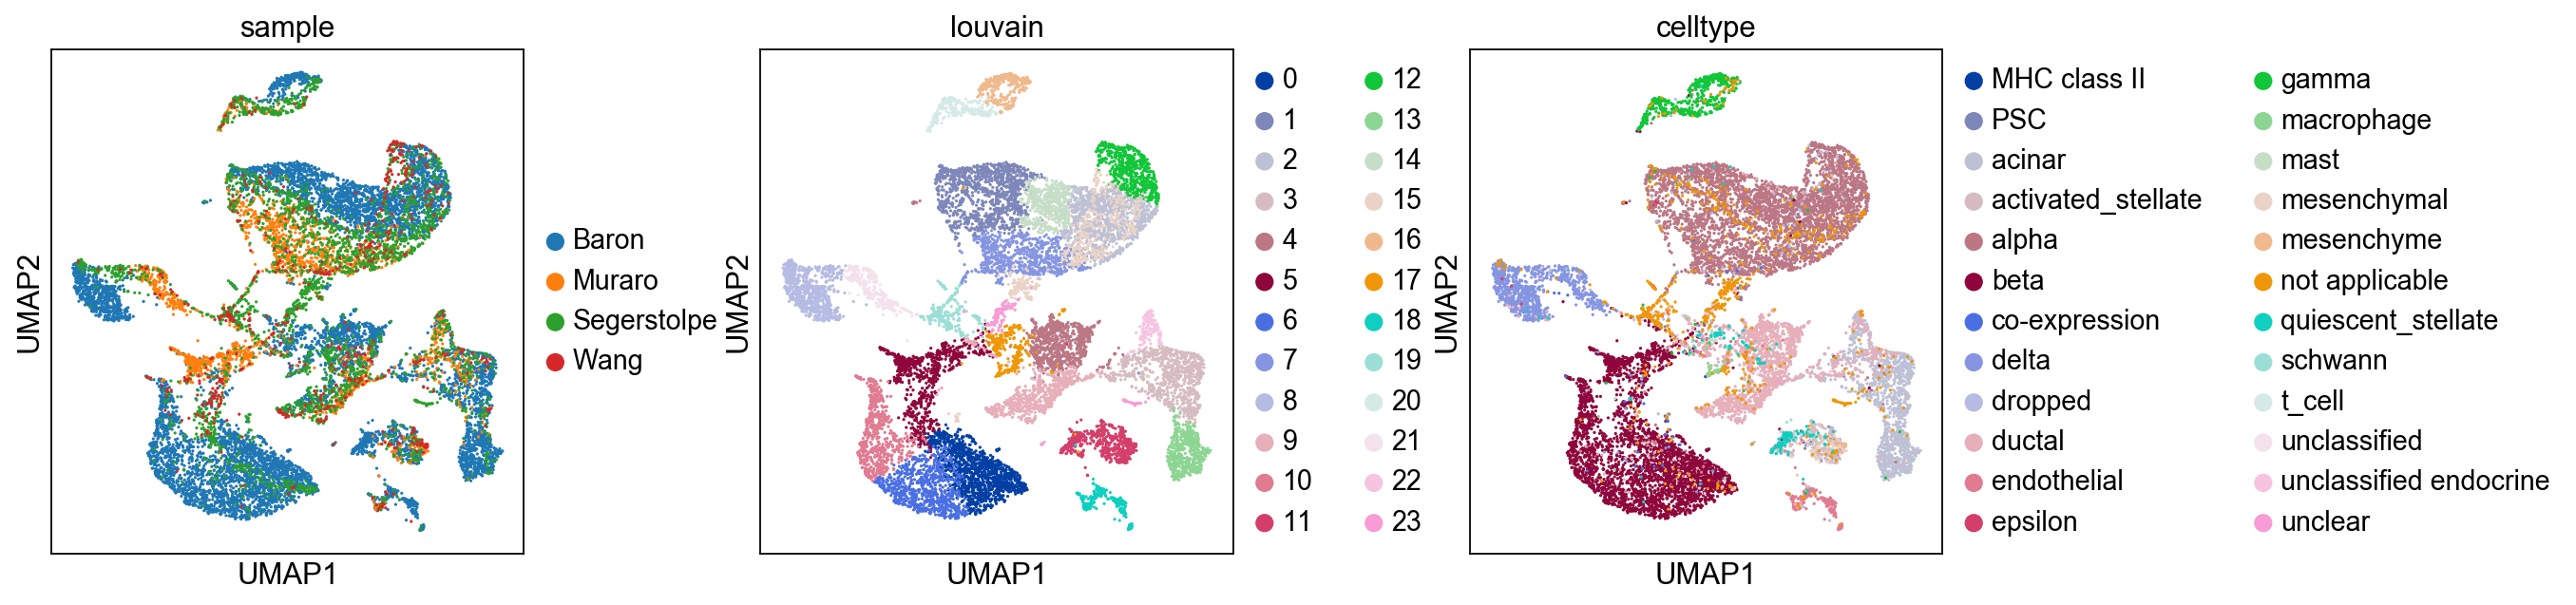

In [6]:
sc.tl.pca(adata_scanorama)
adata_scanorama.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pp.neighbors(adata_scanorama,n_pcs=20, n_neighbors=20)
sc.tl.umap(adata_scanorama)
sc.tl.louvain(adata_scanorama)
sc.pl.umap(adata_scanorama, color=['sample','louvain','celltype'])

The final object export.

In [7]:
adata_scanorama.write('objects-pancreas/pancreas_scanorama.h5ad')